In [8]:
# SPACE OCCUPATION DETECTION 
# https://www.youtube.com/watch?v=caKnQlCMIYI
parkings = fetch_parkings(con)

for p in parkings :
    if p[1] == 'UFPR04':
        # SAMPLE STATIC PARKING CAPTURE
        parking_img = cv.imread(
            'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkDetect\dataset/UFPR04_rainy.jpg')
        img = parking_img
        
        # setupPreprocess(img)
        imgPre = preProcess(img)
        
        parking_id = p[0]
        parking_name = p[1]

        print(f"Parking: {parking_id} - {parking_name}")

        spaces = get_spaces(parking_id)
                
        if len(spaces) > 0:
            for space in spaces:
                id = space[0]
                vertex = np.array(json.loads(space[1]), dtype=np.int32)
                vertex = vertex.reshape(-1, 1, 2)
                was_vacant = get_space_vacant(id) # Fetch de DB to get current space status
                #print(vertex)

                cols = vertex[:, :, 0].flatten()
                rows = vertex[:, :, 1].flatten()
                points = list(zip(cols, rows))
                
                roi = get_roi(imgPre, vertex)
                
                # cv.imshow("roi", roi)

                # Count pixels with value '1'
                count = cv.countNonZero(roi)
                
                # drawSpaceSeg(img, vertex, count)
                # cv.imshow("ROI", roi)
                k = 0.2
                vacant = is_space_vacant(points, count, k) # Depending on the detection area 
                if(vacant != was_vacant): # If status has changed
                    update_space_occupancy(id, vacant) # Update the space occupancy status
                    print("updated status")
                
                cv.imshow("IMG with space seg", drawSpaceSeg(img, np.array(points, np.int32), count, not vacant, min(cols), max(rows)), area(points))
                # cv.waitKey()
                # cv.destroyWindow("roi")

            cv.waitKey()

cv.destroyAllWindows()

Parking: 23 - UFPR04
updated status
updated status
updated status
updated status
updated status
updated status
updated status
updated status
updated status
updated status


In [9]:
# 
import cv2
import numpy as np
import argparse
drawing = False
ix,iy = -1,-1
img = cv2.imread(
            'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkDetect\dataset/UFPR04_sample.jpg')

def mouse_event(event,x,y,flags,param):
    global ix,iy,drawing,mode
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y
    elif event == cv2.EVENT_LBUTTONUP:
        print(ix,iy)
       # print ix,iy
        drawing = False



cv2.namedWindow('image')
cv2.setMouseCallback('image',mouse_event)

while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)], title=''):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(12, 10))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    ax.set_title(title)
    


    # Plot pixel values with colors given in colors_rgb
    if pixels.ndim == 3:
        ax.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    elif pixels.ndim == 2:
        ax.scatter(
            pixels[:, 0].ravel(),
            pixels[:, 1].ravel(),
            pixels[:, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


In [ ]:
def imhist(img):

    bgr_planes = cv.split(img)
    histSize = 256
    histRange = (0, 256) # the upper boundary is exclusive
    accumulate = False
    b_hist = cv.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
    g_hist = cv.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
    r_hist = cv.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)
    hist_w = 512
    hist_h = 400
    bin_w = int(round( hist_w/histSize ))
    histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
    cv.normalize(b_hist, b_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(g_hist, g_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(r_hist, r_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
    for i in range(1, histSize):
        cv.line(histImage, ( bin_w*(i-1), hist_h - int(b_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(b_hist[i]) ),
                ( 255, 0, 0), thickness=2)
        cv.line(histImage, ( bin_w*(i-1), hist_h - int(g_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(g_hist[i]) ),
                ( 0, 255, 0), thickness=2)
        cv.line(histImage, ( bin_w*(i-1), hist_h - int(r_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(r_hist[i]) ),
                ( 0, 0, 255), thickness=2)
    cv.imshow('Source image', img)
    cv.imshow('calcHist Demo', histImage)
    cv.waitKey()

In [ ]:
# DRAWING SPACES SEGMENTATION FOR EACH PARKING
parkings = fetch_parkings(con)

for p in parkings:

    # SAMPLE STATIC PARKING CAPTURE
    parking_img = cv.imread(
        'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkWeb-main\VisionParkWeb\VisionParkWeb\VisionParkWeb\static\drawerJs\parking_sample.jpg')
    image = parking_img

    parking_id = p[0]
    parking_name = p[1]

    print(parking_id, "-", parking_name)

    spaces = get_spaces(parking_id)
    print(len(spaces), ' spaces')

    if len(spaces) > 0:
        for space in spaces:

            vertex = np.array(json.loads(space[1]), dtype=np.int32)
            vertex = vertex.reshape(-1, 1, 2)

            roi = get_roi(image, vertex)
            

            # Convert subsampled image to desired color space(s)
            img_small_RGB = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)  # OpenCV uses BGR, matplotlib likes RGB
            img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

            # Plot and show
            plot3d(img_small_RGB, img_small_rgb)
            plt.show()
            imshow(roi, 'roi')

            isClosed = True
            # Blue color in BGR
            color = (255, 0, 0)
            # Line thickness of 1 px
            thickness = 2

            # Using cv2.polylines() method
            # Draw a Blue polygon with thickness of 1 px
            # image = cv.polylines(image, [vertex], isClosed, color, thickness)

    # Show window
    # while(1):
    #     title = f'[{parking_id}] - {parking_name} - {len(spaces)} spaces'
    #     cv.imshow(title, image)
    #     if cv.waitKey(20) & 0xFF == 27:
    #         break

cv.destroyAllWindows()


In [ ]:
################################################################
#DATA EXTRACTION
################################################################
R = np.empty(1,np.uint8)
G = np.empty(1,np.uint8)
B = np.empty(1,np.uint8)

# https://newbedev.com/how-to-iterate-over-files-in-a-given-directory
directory = 'dataset\empty'
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        
        I = cv.imread(directory + '/' + filename)
        I = cv2.cvtColor(I, cv2.COLOR_BGR2HSV) 
    
        # Append pixel values per channel
        # imread uses BGR channels
        B = np.append(B, I[:,:,0])
        G = np.append(G, I[:,:,1])
        R = np.append(R, I[:,:,2])

# Take a sequence of 1-D arrays and stack them as columns to make a single 2-D array. 
RGB = np.column_stack((B, G, R))

mean = np.mean(RGB, axis = 0)
std = np.std(RGB, axis = 0)

# Plotting RGB values
rgb = RGB / 255.  # scaled to [0, 1], only for plotting
title = f"{np.size(RGB,0)} RGB samples\nMean: {mean}\nStd: {std}"
plot3d(RGB, rgb, title=title)
plt.show()
print(title)



# TODO: Saving to filename
# https://www.kite.com/python/answers/how-to-write-a-variable-to-a-file-in-python

        

In [ ]:
################################################################
#DATA EXTRACTION
################################################################
R = np.empty(1,np.uint8)
G = np.empty(1,np.uint8)
B = np.empty(1,np.uint8)

# https://newbedev.com/how-to-iterate-over-files-in-a-given-directory
directory = 'dataset\occupied'
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        
        I = cv.imread(directory + '/' + filename)
        I = cv.cvtColor(I, cv.COLOR_BGR2HSV) 
    
        # Append pixel values per channel
        # imread uses BGR channels
        B = np.append(B, I[:,:,0])
        G = np.append(G, I[:,:,1])
        R = np.append(R, I[:,:,2])

# Take a sequence of 1-D arrays and stack them as columns to make a single 2-D array. 
RGB = np.column_stack((B, G, R))

mean = np.mean(RGB, axis = 0)
std = np.std(RGB, axis = 0)

# Plotting RGB values
rgb = RGB / 255.  # scaled to [0, 1], only for plotting
title = f"{np.size(RGB,0)} RGB samples\nMean: {mean}\nStd: {std}"
plot3d(RGB, rgb, title=title)
plt.show()
print(title)



# TODO: Saving to filename
# https://www.kite.com/python/answers/how-to-write-a-variable-to-a-file-in-python

        

In [ ]:
import cv2 as cv
import sqlite3
import numpy as np
import json
import os # list directories

# SPACE OCCUPATION DETECTION 
# https://www.youtube.com/watch?v=caKnQlCMIYI
parkings = fetch_parkings(con)

for p, i in enumerate(parkings):

    # SAMPLE STATIC PARKING CAPTURE
    parking_img = cv.imread(
        'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkDetect\dataset/full.jpg')
    img = parking_img

    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    imgBlur = cv.GaussianBlur(imgGray, (3,3), 1)

    imgThreshold = cv.adaptiveThreshold(imgBlur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 25, 16)

    # Remove salt and pepper noise
    imgMedian = cv.medianBlur(imgThreshold, 5)

    # Make thicker edges
    kernel = np.ones((3,3), np.uint8) 
    imgDilate = cv.dilate(imgMedian, kernel, iterations=1)

    parking_id = p[0]
    parking_name = p[1]

    print(parking_id, "-", parking_name)

    spaces = get_spaces(parking_id)
    print(len(spaces), ' spaces')
            
    cv.imshow("IMG", img)
    cv.imshow("IMGTresh", imgThreshold)
    cv.imshow("IMGMedian", imgMedian)
    cv.imshow("IMG Dilate", imgDilate)
    
    cv.waitKey()

    if len(spaces) > 0:
        for space in spaces:

            vertex = np.array(json.loads(space[1]), dtype=np.int32)
            vertex = vertex.reshape(-1, 1, 2)

            roi = get_roi(imgMedian, vertex)

            # Count pixels with value '1'
            count = cv.countNonZero(roi)
            

            cv.imshow("ROI", roi)
            cv.imshow("IMG with space seg", drawSpaceSeg(img, vertex, count))
            cv.waitKey()


cv.destroyAllWindows()

142/142:  E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\UFPR05\Cloudy\2013-03-05\2013-03-05_12_30_07.jpg
Precision: 0.755
Recall: 0.913
F1 Score: 0.827
Accuracy: 0.852


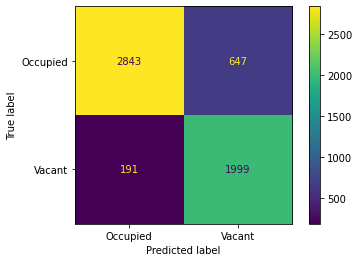

In [24]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\\UFPR05\\Cloudy'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 9, 3, 20) # UPR05
detect_batch(selected_files, params,k=0.26, showImshow=False)


415/415:  E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\UFPR05\Cloudy\2013-03-09\2013-03-09_09_10_03.jpg
Precision: 0.871
Recall: 0.776
F1 Score: 0.821
Accuracy: 0.868


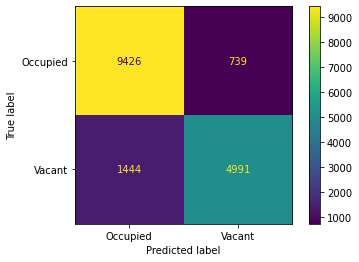

In [15]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\\UFPR05'

files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset
params = DetectionParams((5,5]), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 9, 3, 20) # UPR05
detect_batch(selected_files, params,k=0.2, showImshow=False, setup=False)


415/415:  E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\UFPR05\Sunny\2013-03-11\2013-03-11_18_05_14.jpg
Precision: 0.866
Recall: 0.845
F1 Score: 0.855
Accuracy: 0.878


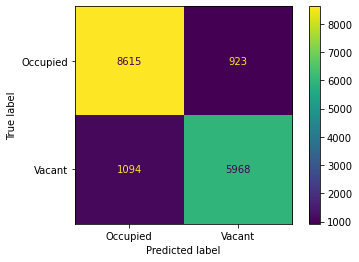

In [2]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\\UFPR05'

files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset
params = DetectionParams((7,7), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 9, 3, 20) # UPR05
detect_batch(selected_files, params,k=0.2, showImshow=False, setup=False)

In [3]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\\UFPR05\\Sunny'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 9, 3, 305) # UPR05
detect_batch(selected_files, params,k=0.26, showImshow=False)


13/250:  E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\UFPR05\Sunny\2013-04-15\2013-04-15_07_05_01.jpg


KeyboardInterrupt: 

207/207:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR05\Sunny\2013-02-24\2013-02-24_12_55_07.jpg
Precision: 0.802
Recall: 0.852
F1 Score: 0.826
Accuracy: 0.851


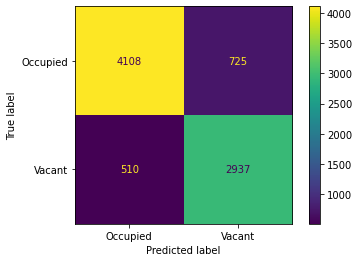

In [7]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR05'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/20))    # Select n random images from dataset

detect_batch(selected_files, showImshow=False)
# BW area open

379/379:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR04\Sunny\2012-12-12\2012-12-12_16_55_13.jpg
Precision: 0.908
Recall: 0.832
F1 Score: 0.868
Accuracy: 0.861


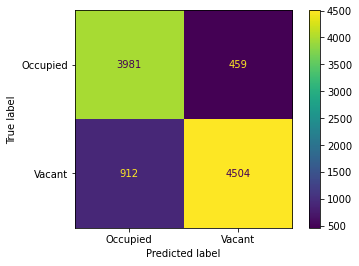

In [20]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob
#params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
#params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 29, 8, 3, 23) # UFPR04

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR04'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params,k=0.26, showImshow=False)
#UPR04

379/379:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR04\Sunny\2012-12-25\2012-12-25_15_10_10.jpg
Precision: 0.902
Recall: 0.831
F1 Score: 0.865
Accuracy: 0.867


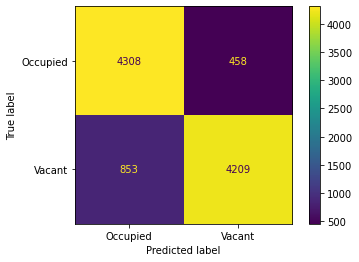

In [4]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 29, 8, 3, 23) # UFPR04

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR04'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params,0.26,  showImshow=False)
#UPR04

447/447:  E:\Documents\PKLot\PKLot\PKLot\PKLot\PUCPR\Sunny\2012-09-18\2012-09-18_06_49_49.jpg
Precision: 0.886
Recall: 0.959
F1 Score: 0.921
Accuracy: 0.912


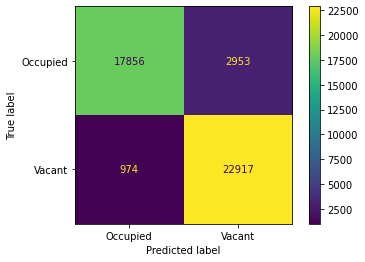

In [27]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\PUCPR'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params, showImshow=False)
#PUCPR

447/447:  E:\Documents\PKLot\PKLot\PKLot\PKLot\PUCPR\Sunny\2012-10-30\2012-10-30_17_47_26.jpg
Precision: 0.905
Recall: 0.895
F1 Score: 0.900
Accuracy: 0.902


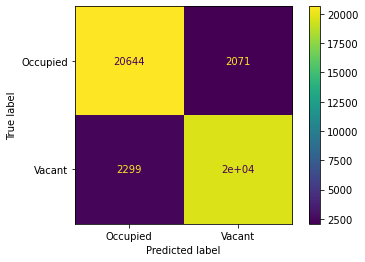

In [21]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\PUCPR'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params,k=0.26, showImshow=False)
#PUCPR

415/415:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR05\Sunny\2013-03-21\2013-03-21_06_30_00.jpg
Precision: 0.844
Recall: 0.827
F1 Score: 0.836
Accuracy: 0.867


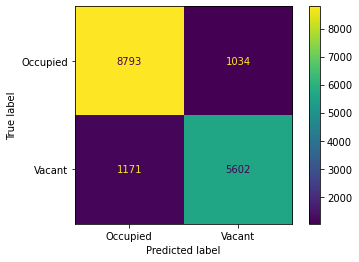

In [19]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob
class DetectionParams:
    def __init__(self, gb_k, gb_s, at_method, at_blockSize, at_C, median_k=-1, bw_size=-1, bw_conn=8):
        self.gb_k = gb_k # GaussianBlur kernel
        self.gb_s = gb_s # GaussianBlur sigma (std. deviation)
        self.at_method = at_method # adaptiveThreshold method
        self.at_blockSize = at_blockSize # adaptiveThreshold blockSizeneighborhood that is used to calculate a threshold value for the pixel
        self.at_C = at_C # adaptiveThreshold C constant to be substracted
        self.median_k = median_k # Median filter kernel size (-1 if not desired to apply)
        self.bw_size = bw_size # bwareaopen remove objects smaller than this size (-1 if not desired to apply)
        self.bw_conn = bw_conn # bwareaopen neighborhood connectivity (default 8)


# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 9, 3, 305) # UPR05

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR05'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params, k=0.22, showImshow=False, setup=False)

#UPR05

100/100:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR05\Cloudy\2013-02-26\2013-02-26_18_54_40.jpg
Precision: 0.575
Recall: 0.996
F1 Score: 0.729
Accuracy: 0.688


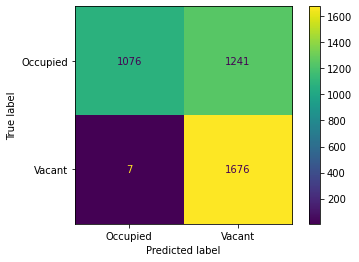

In [17]:
detect_batch(selected_files, params, k=0.35, showImshow=False, setup=False)